<a href="https://colab.research.google.com/github/nestormontano/PrDS_2023_01_WIDS_Prediccion_Energia/blob/main/Scripts/WIDS2022_Prediccion_Energia__EDA_r_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto Programa Data Science WIDS - Prediccion de Energia

Con R

Sitio del concurso: https://www.kaggle.com/c/widsdatathon2022

Datos: https://drive.google.com/drive/folders/1BxbUc5k1DowoyIvRurX1Iw8ksyIrLzBE?usp=share_link


En R no pueden conectarse a Google Drive, pueden  seguir las instrucciones dadas en el pdf para  
- Ser invitados como colaboradores del repositorio en GitHub
- Conectar el Colab con su drive 
- Escribir en GitHub los cambios para que se noten sus aportes.

#### Preliminares

In [22]:
library(tidyverse)
library(magrittr)
library(ggcorrplot)
library(skimr)

### Descargar los datos

In [ ]:
# https://drive.google.com/file/d/1PdeAFd0I1XLZ8WEaFbpBXB18QDWZMyXo/view?usp=sharing
system("gdown --id 1PdeAFd0I1XLZ8WEaFbpBXB18QDWZMyXo")

## EDA

### Importar, corregir Datos y unir

In [ ]:
datos= read_csv('train.csv')

Rows: 75757 Columns: 64
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): State_Factor, building_class, facility_type
dbl (61): Year_Factor, floor_area, year_built, energy_star_rating, ELEVATION...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
datos %>% glimpse

Rows: 75,757
Columns: 64
$ Year_Factor               <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ State_Factor              <chr> "State_1", "State_1", "State_1", "State_1", …
$ building_class            <chr> "Commercial", "Commercial", "Commercial", "C…
$ facility_type             <chr> "Grocery_store_or_food_market", "Warehouse_D…
$ floor_area                <dbl> 61242, 274000, 280025, 55325, 66000, 119900,…
$ year_built                <dbl> 1942, 1955, 1951, 1980, 1985, 1956, 1982, 19…
$ energy_star_rating        <dbl> 11, 45, 97, 46, 100, NA, 56, 99, 98, 83, 51,…
$ ELEVATION                 <dbl> 2.4, 1.8, 1.8, 1.8, 2.4, 2.4, 2.4, 2.4, 2.4,…
$ january_min_temp          <dbl> 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, …
$ january_avg_temp          <dbl> 50.5, 50.5, 50.5, 50.5, 50.5, 50.5, 50.5, 50…
$ january_max_temp          <dbl> 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, 68, …
$ february_min_temp         <dbl> 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, …
$ february_avg_

In [ ]:
datos %<>% mutate(id= as.character(id), Year_Factor= as.character(Year_Factor))

### EDA univariado

Para encontrar qué variables deben ser excluidas del modelo, si se requiere alguna transformación, etc.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


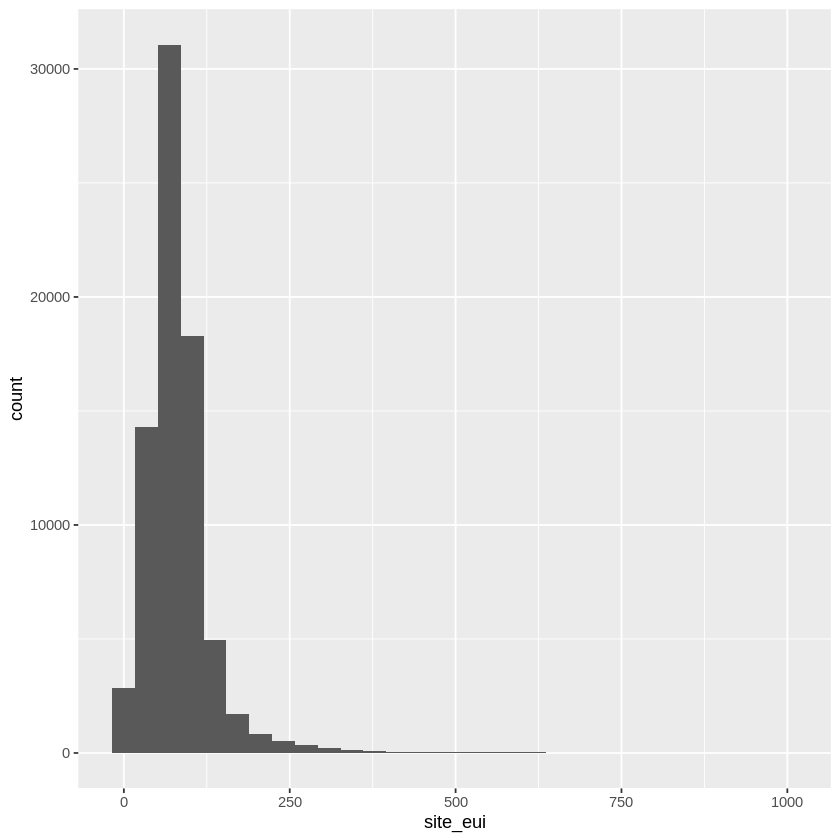

In [ ]:
# Histograma del consumo energetico
datos %>% ggplot() + geom_histogram(aes(x=site_eui)) #+ xlim(0,250)

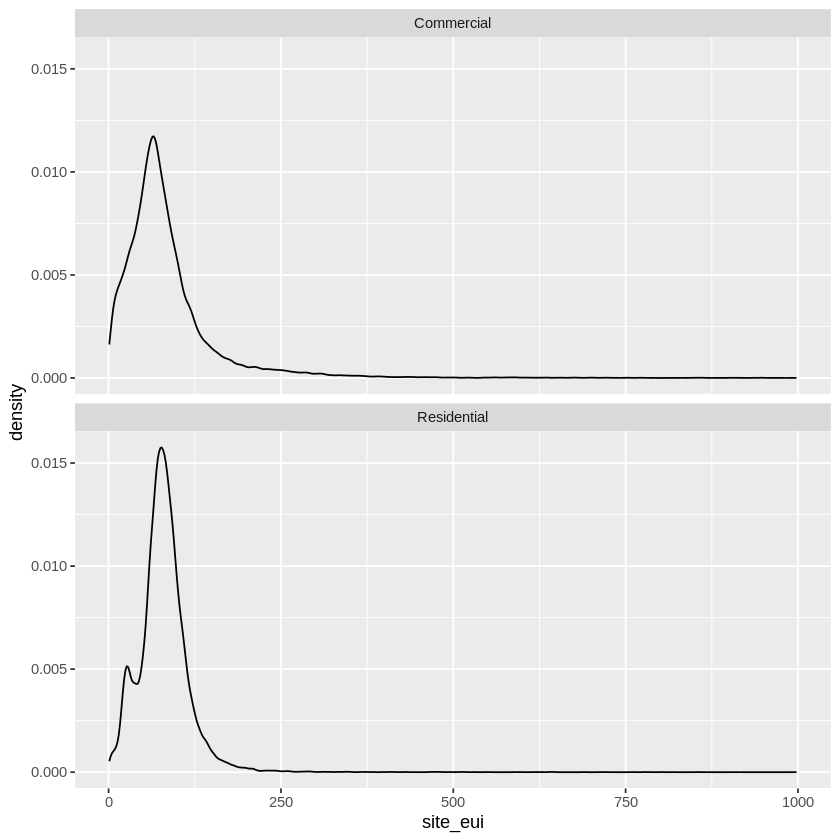

In [ ]:
# Diagrama de densidad del consumo energetico (para cada tipo de edificio)
datos %>% ggplot() + geom_density(aes(x=site_eui)) + facet_wrap(~building_class, ncol = 1)

In [ ]:
# Tabla de frecuencia por estado
datos %>% 
  group_by(State_Factor) %>% 
  summarise(f= n(), 
            site_eui_sum= sum(site_eui), 
            site_eui_mean= mean(site_eui)) %>% 
  ungroup() %>% 
  mutate(rf= round((f/sum(f))*100,2)) %>%
  relocate(rf, .after = f)

State_Factor,f,rf,site_eui_sum,site_eui_mean
<chr>,<int>,<dbl>,<dbl>,<dbl>
State_1,5618,7.42,349418.219,62.19619
State_10,15,0.02,1028.956,68.59708
State_11,6412,8.46,346178.970,53.98923
State_2,4871,6.43,379324.148,77.87398
State_4,4300,5.68,409356.951,95.19929
State_6,50840,67.11,4447534.632,87.48101
State_8,3701,4.89,323526.683,87.41602


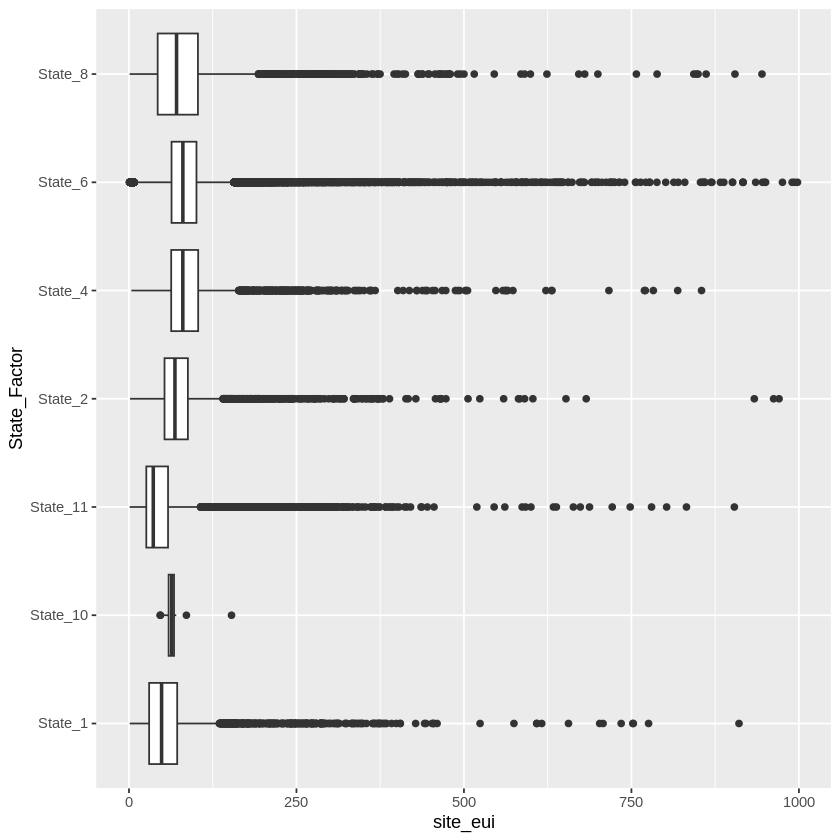

In [ ]:
# Diagramas de caja den consumo energetico (por estado)
datos %>% ggplot() + geom_boxplot(aes(x= State_Factor, y= site_eui)) + coord_flip()

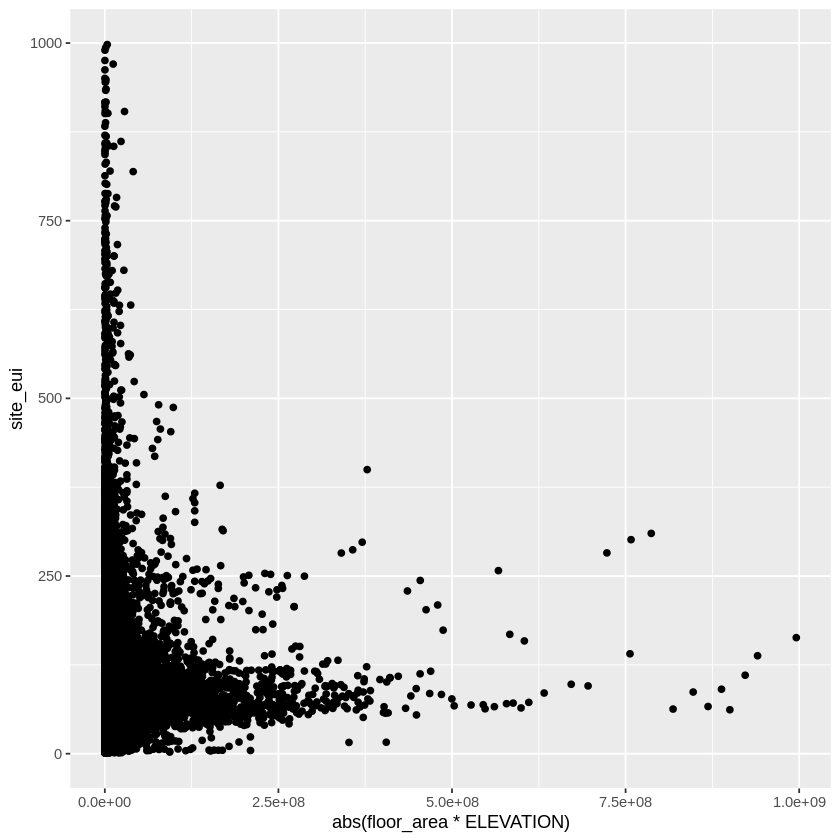

In [ ]:
datos %>% ggplot() + geom_point(aes(x= abs(floor_area*ELEVATION), y= site_eui))

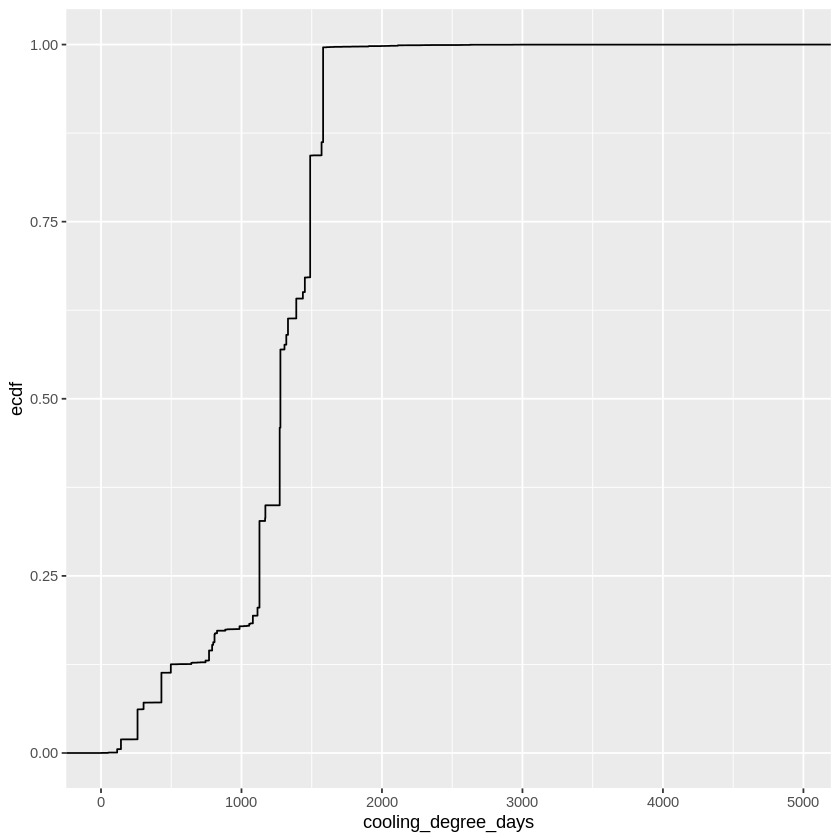

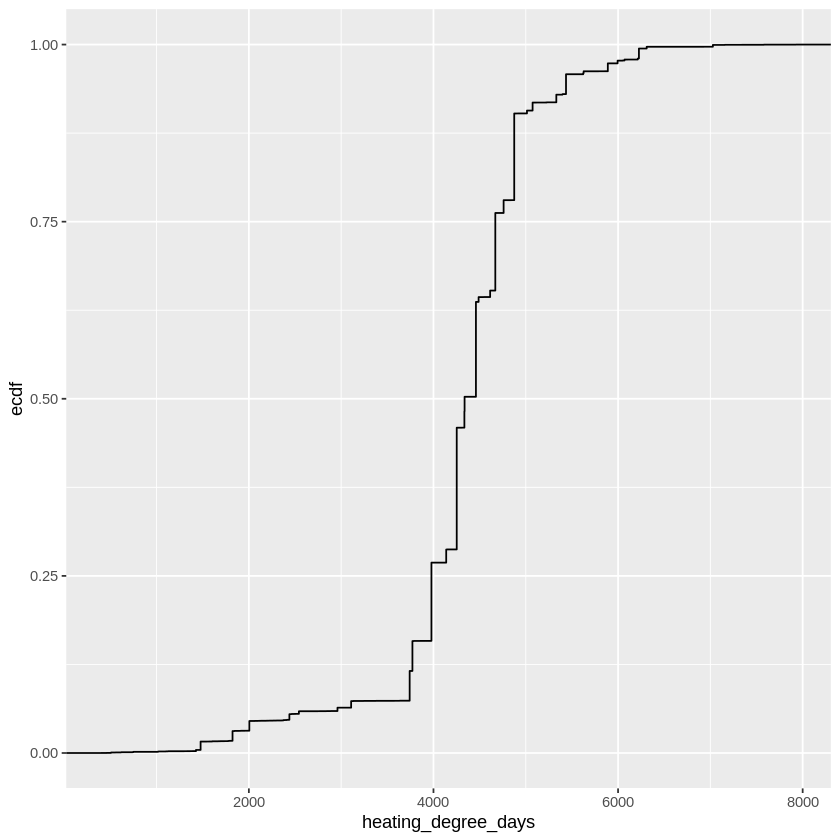

In [ ]:
# Diagrama de frecuencia acumulada
datos %>% ggplot(aes(cooling_degree_days)) + geom_step(stat ="ecdf" )
datos %>% ggplot(aes(heating_degree_days)) + geom_step(stat ="ecdf" )

#### ++ Variables con demasiados NA

In [39]:
# Construcciones con year_built==0 se consideran NAs
datos %<>% mutate(year_built= if_else(year_built==0, NA_real_, year_built ))

NACols <- names(datos %>% summarise_all(~(sum(is.na(.)))) %>% select_if(. > 0))

skimr::skim(datos %>% select(NACols))

#Se recomienda excluir las variables con un completion rate inferior al 70% para futuros análisis

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(NACols)

  # Now:
  data %>% select(all_of(NACols))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


── Data Summary ────────────────────────
                           Values                  
Name                       datos %>% select(NACols)
Number of rows             75757                   
Number of columns          6                       
_______________________                            
Column type frequency:                             
  numeric                  6                       
________________________                           
Group variables            None                    

── Variable type: numeric ──────────────────────────────────────────────────────
  skim_variable             n_missing complete_rate    mean     sd   p0  p25
1 year_built                     1843         0.976 1952.    32.6  1600 1927
2 energy_star_rating            26709         0.647   61.0   28.7     0   40
3 direction_max_wind_speed      41082         0.458   66.6  131.      1    1
4 direction_peak_wind_speed     41811         0.448   62.8  130.      1    1
5 max_wind_speed        

Warning message in is.null(text_repr) || nchar(text_repr) == 0L:
“'length(x) = 12 > 1' in coercion to 'logical(1)'”


,skim_type,skim_variable,n_missing,complete_rate,numeric.mean,numeric.sd,numeric.p0,numeric.p25,numeric.p50,numeric.p75,numeric.p100,numeric.hist
,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,numeric,year_built,1843,0.9756722,1952.465243,32.613687,1600,1927,1951,1977,2015.0,▁▁▁▅▇
2,numeric,energy_star_rating,26709,0.6474385,61.048605,28.663683,0,40,67,85,100.0,▃▃▅▆▇
3,numeric,direction_max_wind_speed,41082,0.4577135,66.552675,131.147834,1,1,1,1,360.0,▇▁▁▁▂
4,numeric,direction_peak_wind_speed,41811,0.4480906,62.779974,130.308106,1,1,1,1,360.0,▇▁▁▁▂
5,numeric,max_wind_speed,41082,0.4577135,4.190601,6.458789,1,1,1,1,23.3,▇▁▁▁▁
6,numeric,days_with_fog,45796,0.3954882,109.142051,50.699751,12,88,104,131,311.0,▂▇▁▁▁


#### ++ Variables con varianza cercana a cero

In [97]:
mean= as_vector(datos %>% select_if(is.numeric) %>% select(!NACols) %>% apply(2, mean))
sd= as_vector(datos %>% select_if(is.numeric) %>% select(!NACols) %>% apply(2, sd))

transition_df <- tibble(names(mean), mean, sd)

transition_df %>% mutate(coef_cv= sd/mean) %>% filter(coef_cv<0.05) %>% arrange(coef_cv)

names(mean),mean,sd,coef_cv
<chr>,<dbl>,<dbl>,<dbl>
may_max_temp,88.98786,2.864669,0.03219169
june_max_temp,91.40028,3.604068,0.03943170
avg_temp,56.17670,2.241940,0.03990871
june_avg_temp,71.06638,2.861681,0.04026772
july_max_temp,95.54395,4.157118,0.04351000
may_avg_temp,63.74255,2.792919,0.04381561
august_max_temp,92.57258,4.139685,0.04471827
october_avg_temp,58.72704,2.641300,0.04497587
april_avg_temp,53.78486,2.500473,0.04649027


In [100]:
#Experimento y dudas (LCHP&EMLO)
test_df <- 
  datos %>% 
  rowwise() %>% 
  mutate(WinterAvg= mean(c(january_avg_temp, february_avg_temp, march_avg_temp), na.rm=T),
         SpringAvg= mean(c(april_avg_temp, may_avg_temp, june_avg_temp), na.rm=T),
         SummerAvg= mean(c(july_avg_temp, august_avg_temp, september_avg_temp), na.rm=T),
         AutumnAvg= mean(c(october_avg_temp, november_avg_temp, december_avg_temp), na.rm=T),
         year_min_temp = min(january_min_temp, february_min_temp, march_min_temp, 
                             april_min_temp, may_min_temp, june_min_temp, 
                             july_min_temp, august_min_temp, september_min_temp, 
                             october_min_temp, november_min_temp, december_min_temp),
         year_max_temp = max(january_max_temp, february_max_temp, march_max_temp, 
                             april_max_temp, may_max_temp, june_max_temp, 
                             july_max_temp, august_max_temp, september_max_temp, 
                             october_max_temp, november_max_temp, december_max_temp))

mean2= as_vector(test_df %>% select_if(is.numeric) %>% select(!NACols) %>% apply(2, mean))
sd2= as_vector(test_df %>% select_if(is.numeric) %>% select(!NACols) %>% apply(2, sd))

transition_df <- tibble(names(mean2),mean2,sd2)

transition_df %>% mutate(coef_cv= sd2/mean2) %>% filter(coef_cv<0.05) %>% arrange(coef_cv)

names(mean2),mean2,sd2,coef_cv
<chr>,<dbl>,<dbl>,<dbl>
SpringAvg,62.86460,1.830177,0.02911299
may_max_temp,88.98786,2.864669,0.03219169
year_max_temp,96.51735,3.255677,0.03373152
june_max_temp,91.40028,3.604068,0.03943170
avg_temp,56.17670,2.241940,0.03990871
june_avg_temp,71.06638,2.861681,0.04026772
july_max_temp,95.54395,4.157118,0.04351000
may_avg_temp,63.74255,2.792919,0.04381561
august_max_temp,92.57258,4.139685,0.04471827


#### Conclusiones

### EDA Multivariado

Para encontrar relaciones entre variables, variables que pueden producir tener multicolinearidad o concurvidad, etc.

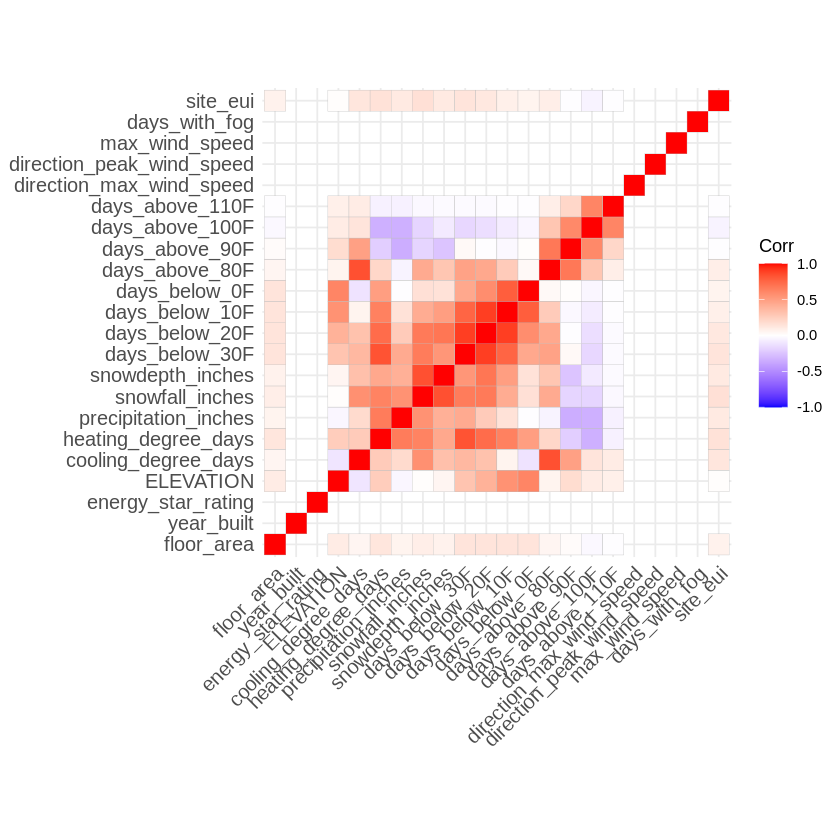

In [ ]:
# Matriz de correlacion (se excluyen variables tipo string y temperaturas mensuales)
ggcorrplot(cor(datos[, !sapply(datos, is.character)] %>% select(-contains("temp"))))

#### ++ Variables con alta correlación